## Solana Price Prediction

This Notebook is an attempt to provide an estimate of the price of Solana in one year following the Bitcoin halving.  A distinction between cryptocurrencies and traditional stocks is that the circulating supply is typically always increasing for cryptocurrencies.  This can dilute future prices.  Here I use a model based on the market caps of Bitcoin and Ethereum and an extrapolation of Solana circulating supply in a year to make a prediction for price.

Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress as regress
from scipy.signal import butter, filtfilt
import requests, sys
from datetime import datetime as dt
from cg_functions import coin_price

In [2]:
base_url = 'https://api.coingecko.com/api/v3'

In [3]:
coin_id = 'solana'
coin_ticker = 'SOL'
print(f"You have selected: {coin_id} ({coin_ticker})")

You have selected: solana (SOL)


Input date range

In [4]:
string_startdate = '01/01/2023'
string_enddate = '10/27/2023'

start_datetime = dt.strptime(string_startdate, "%m/%d/%Y")
end_datetime = dt.strptime(string_enddate, "%m/%d/%Y")

start_tstamp = dt.timestamp(start_datetime)
end_tstamp = dt.timestamp(end_datetime)

Function to make API url

In [5]:
def make_url(token, start, end):
    url = f"{base_url}/coins/{token}/market_chart/range?vs_currency=usd&from={start}&to={end}&precision=full"
    return url

Bitcoin

In [6]:
url = make_url("bitcoin", start_tstamp, end_tstamp)
btc = requests.get(url)
btc_data = pd.DataFrame.from_dict(btc.json())
btc_data

,prices,market_caps,total_volumes
0,"[1672617600000, 16615.969318012816]","[1672617600000, 319832024054.6308]","[1672617600000, 9799252684.089952]"
1,"[1672704000000, 16674.342536301097]","[1672704000000, 321486454934.26776]","[1672704000000, 13023861027.769472]"
2,"[1672790400000, 16677.646185850346]","[1672790400000, 321080820418.18396]","[1672790400000, 15367167883.495031]"
3,"[1672876800000, 16855.1747387671]","[1672876800000, 324397588037.39484]","[1672876800000, 20836560771.723633]"
4,"[1672963200000, 16832.098988497855]","[1672963200000, 324138957221.0557]","[1672963200000, 14919039445.106901]"
...,...,...,...
294,"[1698019200000, 30019.38050086351]","[1698019200000, 583399133857.2509]","[1698019200000, 11330304246.065748]"
295,"[1698105600000, 32953.262760830985]","[1698105600000, 641535355789.0791]","[1698105600000, 35558857925.14893]"
296,"[1698192000000, 33846.72425733224]","[1698192000000, 660676033939.1393]","[1698192000000, 46464714676.18555]"
297,"[1698278400000, 34471.986031672015]","[1698278400000, 673948847498.8158]","[1698278400000, 23840463172.498646]"


Ethereum

In [7]:
url = make_url("ethereum", start_tstamp, end_tstamp)
eth = requests.get(url)
eth_data = pd.DataFrame.from_dict(eth.json())
eth_data

,prices,market_caps,total_volumes
0,"[1672617600000, 1200.65921690107]","[1672617600000, 144712215098.15164]","[1672617600000, 2179799161.0385365]"
1,"[1672704000000, 1214.3789459253508]","[1672704000000, 146443084804.90094]","[1672704000000, 3845095582.093461]"
2,"[1672790400000, 1214.760969419338]","[1672790400000, 146422424046.4976]","[1672790400000, 3385566691.456905]"
3,"[1672876800000, 1256.4366037834864]","[1672876800000, 151322902029.0838]","[1672876800000, 6727208484.546551]"
4,"[1672963200000, 1250.7922522355914]","[1672963200000, 150805231900.39493]","[1672963200000, 4052351544.8201857]"
...,...,...,...
294,"[1698019200000, 1664.5706380939323]","[1698019200000, 197491207720.22275]","[1698019200000, 8470836764.501468]"
295,"[1698105600000, 1764.9303085804013]","[1698105600000, 212527885674.17044]","[1698105600000, 23272549997.825783]"
296,"[1698192000000, 1784.773410988584]","[1698192000000, 214740097898.5592]","[1698192000000, 28137390855.35382]"
297,"[1698278400000, 1785.555149097494]","[1698278400000, 214935538924.01108]","[1698278400000, 15647597829.544785]"


Coin Chosen Above

In [8]:
url = make_url(coin_id, start_tstamp, end_tstamp)
coins = requests.get(url)
coin_data = pd.DataFrame.from_dict(coins.json())
time = pd.date_range(string_startdate, string_enddate, freq='1D'); time = time[:-1:]

Loop to reverse order

In [9]:
ntime = len(time)
tstamp = np.nan*np.ones((ntime, ))
price = np.nan*np.ones((ntime, ))
market_cap = np.nan*np.ones((ntime, ))

btc_price = np.nan*np.ones((ntime, ))
btc_market_cap = np.nan*np.ones((ntime, ))

eth_price = np.nan*np.ones((ntime, ))
eth_market_cap = np.nan*np.ones((ntime, ))

for n in range(ntime):
    P = np.array(coin_data.prices[n])
    M = np.array(coin_data.market_caps[n])
    price[n] = P[-1]
    market_cap[n] = M[-1]
    tstamp[n] = M[0]
    
    P = np.array(btc_data.prices[n])
    M = np.array(btc_data.market_caps[n])
    btc_price[n] = P[-1]
    btc_market_cap[n] = M[-1]
    
    P = np.array(eth_data.prices[n])
    M = np.array(eth_data.market_caps[n])
    eth_price[n] = P[-1]
    eth_market_cap[n] = M[-1]
    
supply = market_cap/price

Emission Rate

In [10]:
p = np.polyfit(tstamp, supply, 1)
supply_fit = np.polyval(p, tstamp)
stats = regress(tstamp, supply)
emission = p[0]*86400000 # per day
f"The emission rate is {emission/1e3:0.4}k coins per day"

'The emission rate is 163.5k coins per day'

In [11]:
# plt.plot(time, price)
ntime, np.size(price)

(299, 299)

In [12]:
# plt.plot(time, price)
type(price), type(time)

(numpy.ndarray, pandas.core.indexes.datetimes.DatetimeIndex)

In [13]:
whos

Variable           Type                Data/Info
------------------------------------------------
M                  ndarray             2: 2 elems, type `float64`, 16 bytes
P                  ndarray             2: 2 elems, type `float64`, 16 bytes
base_url           str                 https://api.coingecko.com/api/v3
btc                Response            <Response [200]>
btc_data           DataFrame                                    <...>n\n[299 rows x 3 columns]
btc_market_cap     ndarray             299: 299 elems, type `float64`, 2392 bytes
btc_price          ndarray             299: 299 elems, type `float64`, 2392 bytes
butter             function            <function butter at 0x15bad54e0>
coin_data          DataFrame                                    <...>n\n[299 rows x 3 columns]
coin_id            str                 solana
coin_price         function            <function coin_price at 0x15bfb2980>
coin_ticker        str                 SOL
coins              Response    

Text(0, 0.5, 'Market Cap [$B]')

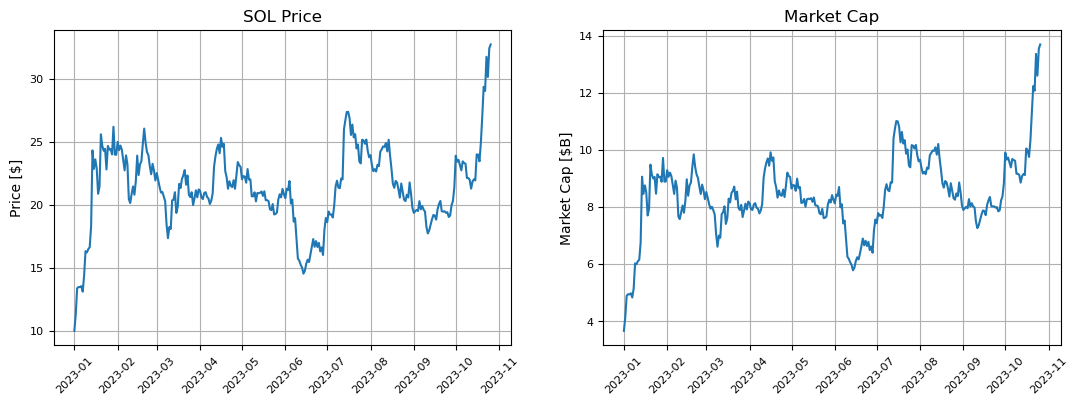

In [14]:
time = pd.date_range(string_startdate, string_enddate, freq='1D'); time = time[:-1:]
plt.rcParams["figure.figsize"] = (13, 9)

plt.subplot(221)
plt.plot(time, price)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.grid(True)
plt.title(coin_ticker + ' Price')
plt.ylabel('Price [$]')

plt.subplot(222)
plt.plot(time, market_cap/1e9)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.grid(True)
plt.title('Market Cap')
plt.ylabel('Market Cap [$B]')

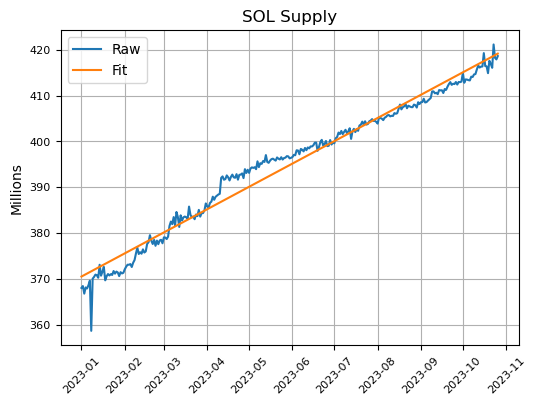

In [15]:
plt.subplot(221)
plt.plot(time, supply/1e6, time, supply_fit/1e6)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.grid(True)
plt.title(coin_ticker + ' Supply')
plt.ylabel('Millions')
plt.legend(('Raw', 'Fit'))

What will the circulating supply be in 1 year?

In [16]:
supply_1Y = supply[-1] + emission*365
print(f"Circulating supply in 1 year will be {supply_1Y/1e6:0.5}M")

Circulating supply in 1 year will be 478.32M


What will the price be in 1 year if the market cap is $100B?

In [17]:
P_1Y_100B = 100e9/supply_1Y
print(f"Price in 1 year will be ${P_1Y_100B:0.5} with a market cap of $100B")

Price in 1 year will be $209.06 with a market cap of $100B


What will the price be in 1 year with a return to market cap ATH $75B?

In [18]:
P_1Y_75B = 75e9/supply_1Y
print(f"Price in 1 year will be ${P_1Y_75B:0.5} with a market cap of $75B")

Price in 1 year will be $156.8 with a market cap of $75B


## Price model for coin based on BTC and ETH

We can model the price by the market cap relationship with Bitcoin and Ethereum.

The price of SOL based on the market cap of BTC:
$$\displaystyle P^{sol}_{btcmod} = \overline{\left(\frac{M_{sol}}{M_{btc}}\right)}\frac{M_{btc}(t)}{S_{fit}(t)}$$

The price of SOL based on the market cap of ETH:
$$\displaystyle P^{sol}_{ethmod} = \overline{\left(\frac{M_{sol}}{M_{eth}}\right)}\frac{M_{eth}(t)}{S_{fit}(t)}$$



In [19]:
mc_btc_ratio = np.mean(market_cap/btc_market_cap)
mc_eth_ratio = np.mean(market_cap/eth_market_cap)

P_btcmodel = mc_btc_ratio*btc_market_cap/supply_fit
P_ethmodel = mc_eth_ratio*eth_market_cap/supply_fit

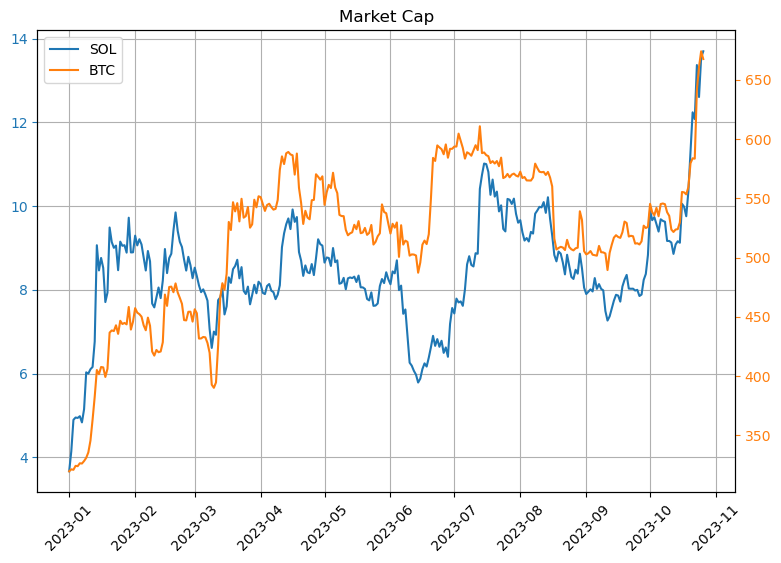

In [20]:
# plt.rcParams["figure.figsize"] = (13, 9)
plt.rcParams["figure.figsize"] = (9, 6)

fig, ax = plt.subplots()
ax1 = ax
line1 = ax1.plot(time, market_cap/1e9, color='C0') 
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)
plt.title('Market Cap')

ax2 = ax1.twinx()
line2 = ax2.plot(time, btc_market_cap/1e9, color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.tick_params(axis='x', rotation=45)

lines = line1 + line2 
ax2.legend(lines, [coin_ticker, 'BTC'], loc=2)

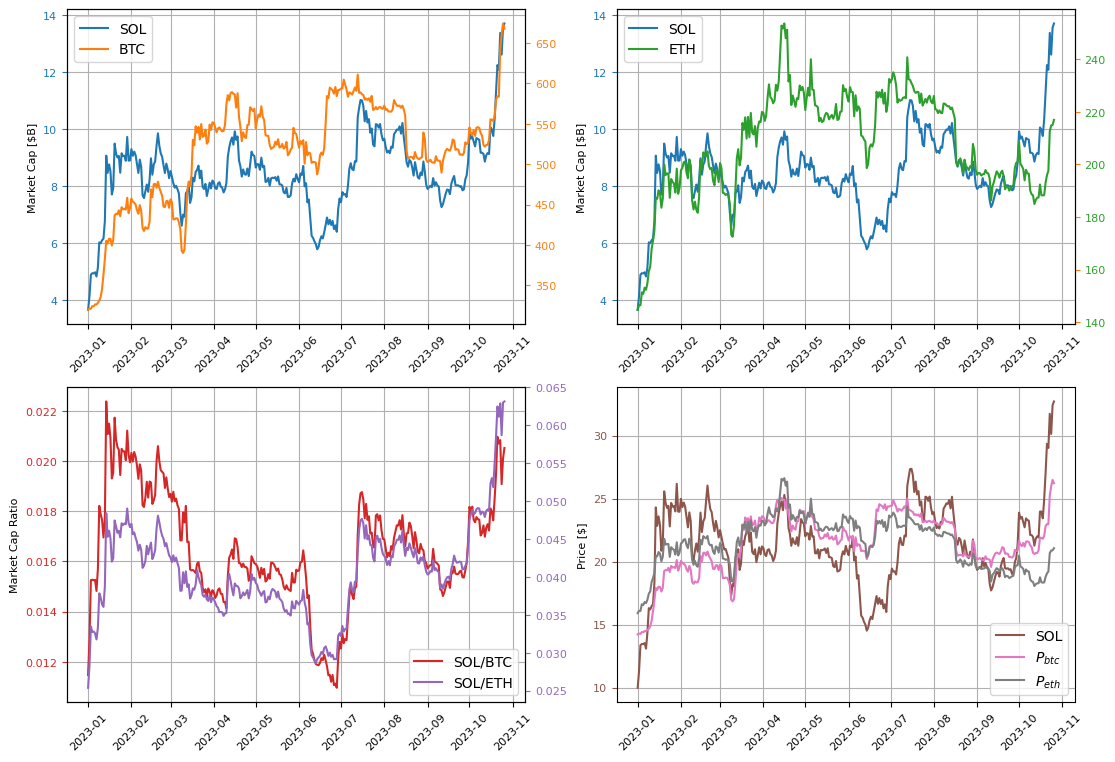

In [21]:
plt.rcParams["figure.figsize"] = (13, 9)
fntsize = 8

nrows = 2; ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)

ax1 = ax[0, 0]
line1 = ax1.plot(time, market_cap/1e9, color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', labelsize=fntsize)
ax1.grid(True)
ax1.set_ylabel('Market Cap [$B]', fontsize=fntsize)

ax2 = ax1.twinx()
line2 = ax2.plot(time, btc_market_cap/1e9, color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='both', labelsize=fntsize)
 
lines = line1 + line2 
ax2.legend(lines, [coin_ticker, 'BTC'], loc=2)

ax1 = ax[0, 1]
line1 = ax1.plot(time, market_cap/1e9, color='C0') 
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', labelsize=fntsize)
ax1.grid(True)
ax1.set_ylabel('Market Cap [$B]', fontsize=fntsize)

ax2 = ax1.twinx()
line2 = ax2.plot(time, eth_market_cap/1e9, color='C2')
ax2.tick_params(axis='y', color='C1', labelcolor='C2')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='both', labelsize=fntsize)

lines = line1 + line2 
ax2.legend(lines, [coin_ticker, 'ETH'], loc=2)

ax1 = ax[1, 0]
line1 = ax1.plot(time, market_cap/btc_market_cap, color='C3')
ax1.tick_params(axis='y', color='C3', labelcolor='C3')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', labelsize=fntsize)
ax1.grid(True)
ax1.set_ylabel('Market Cap Ratio', fontsize=fntsize)

ax2 = ax1.twinx()
line2 = ax2.plot(time, market_cap/eth_market_cap, color='C4')
ax2.tick_params(axis='y', color='C4', labelcolor='C4')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='both', labelsize=fntsize)

lines = line1 + line2 
ax2.legend(lines, [coin_ticker + '/BTC', coin_ticker + '/ETH'], loc=4)

ax1 = ax[1, 1]
line1 = ax1.plot(time, price, color='C5')
ax1.tick_params(axis='y', color='C5', labelcolor='C5')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', labelsize=fntsize)
ax1.grid(True)
ax1.set_ylabel('Price [$]', fontsize=fntsize)

line2 = ax1.plot(time, P_btcmodel, color='C6')
line3 = ax1.plot(time, P_ethmodel, color='C7')

lines = line1 + line2 + line3
ax1.legend(lines, [coin_ticker, '$P_{btc}$', '$P_{eth}$'], loc=4)


In [22]:
corr = np.corrcoef(market_cap, btc_market_cap)
R_btc = corr[0, 1]

corr = np.corrcoef(market_cap, eth_market_cap)
R_eth = corr[0, 1]

print(f"Correlation between {coin_ticker} & BTC market cap = {R_btc:0.2}")
print(f"Correlation between {coin_ticker} & ETH market cap = {R_eth:0.2}")

Correlation between SOL & BTC market cap = 0.56
Correlation between SOL & ETH market cap = 0.4


## Where will the price of Solana be in one year following the Bitcoin halving?

If the market cap of BTC is \\$3T in one year and the market cap of ETH is half BTC at \\$1.5T we can model the price of SOL from the projected supply

In [23]:
BTC_MC_1Y = 3e12
ETH_MC_1Y = BTC_MC_1Y/2

P_sol_1Y_btcmod = mc_btc_ratio*BTC_MC_1Y/supply_1Y
P_sol_1Y_ethmod = mc_eth_ratio*ETH_MC_1Y/supply_1Y

In [24]:
print(f"The price of SOL in one year would be {P_sol_1Y_btcmod:0.5} based on BTC model")
print(f"The price of SOL in one year would be {P_sol_1Y_ethmod:0.5} based on ETH model")

The price of SOL in one year would be 103.29 based on BTC model
The price of SOL in one year would be 127.69 based on ETH model


What would the market cap need to be in one year for Solana to return to ATHs?

In [25]:
M_ath = 250*supply_1Y/1e9
print(f"For SOL to return to ATHs at $250 in one year, it would need a market cap of ${M_ath:0.5}B")

For SOL to return to ATHs at $250 in one year, it would need a market cap of $119.58B
